### Data Generation

#### Создание файлов со всей необходимой информацией о данных

1. Загружаем все таблицы и колонки, которые я предварительно сгенерировал и сохраняем в schema
2. Генерируем файл со всеми названиями таблиц и колонок dict.txt
3. Выполняем one-hot-encoding для названий всех таблиц и колонок, записываем результирующие векторы в файл encoded_dict.txt

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
random.seed(42)

In [2]:
file = open('schema.txt')
schema = {}

for row in file:
    [table, columns] = row.split(':')
    columns = columns.split('\n')[0]
    columns = columns.split(', ')
    schema[table] = columns

In [3]:
cumul_sum = np.cumsum([len(schema[table]) for table in schema.keys()])

In [4]:
with open('dict.txt', 'w'): pass
with open('encoded_dict.txt', 'w'): pass

In [5]:
diction = open('dict.txt', 'a')
file = open('schema.txt')
for row in file:
    [table, columns] = row.split(':')
    diction.write(table + ', ' + columns)

In [6]:
def load_dictionary(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        words = [word.strip() for line in lines for word in line.split(',')]
    return words

def one_hot_encoding(words, file_path):
    unique_words = sorted(set(words))
    word_to_index = {word: i for i, word in enumerate(unique_words)}
    encoded_vectors = []

    for word in words:
        vector = [0] * len(unique_words)
        vector[word_to_index[word]] = 1
        encoded_vectors.append(vector)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.truncate(0)  # Очистка файла перед записью новых данных
        for vector in encoded_vectors:
            encoded_line = ','.join(map(str, vector))
            file.write(encoded_line + '\n')

if __name__ == "__main__":
    input_file = 'dict.txt'
    output_file = 'encoded_dict.txt'

    words = load_dictionary(input_file)
    one_hot_encoding(words, output_file)

#### Генерация графов (схем БД) как подвыборки таблиц и соответствующих им колонок

In [7]:
# Генерация схемы базы данных
def gen_db(schema):
    tables = list(schema.keys())
    length = len(tables)
    count = random.randint(length//2, length)
    r = random.sample(range(length), count)
    
    gen_schema = {}
    for num in r:
        gen_schema[tables[num]] = schema[tables[num]]
    return gen_schema, r

In [8]:
# Создание графа на основе сгенерированной схемы базы данных
def generate_graph(schema):
    graph = nx.Graph()
    gen_schema, r = gen_db(schema)
    
    for table in gen_schema.keys():
        graph.add_node(table)
        for column in gen_schema.get(table):
            graph.add_node(column)
            graph.add_edge(table,column)
            
    return graph, r

### Визуализация графа

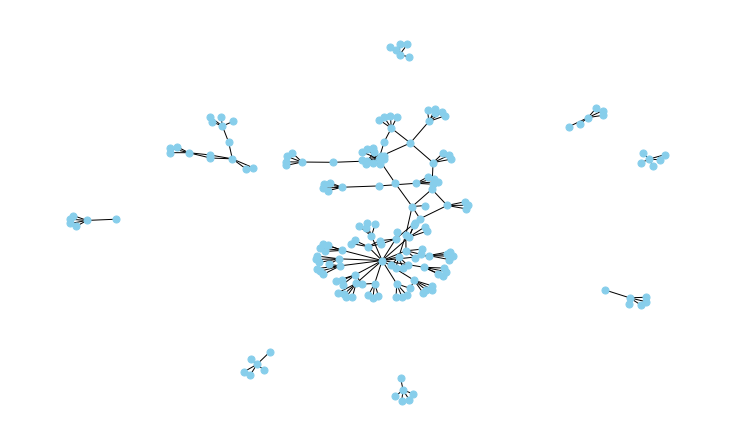

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

g, r = gen_db(schema)
g, r = generate_graph(g)

pos = nx.spring_layout(g)
plt.figure(figsize=(10, 6))
nx.draw(g, pos, node_size=50, node_color='skyblue', with_labels=False, font_weight='bold')

#plt.savefig("graph.png")
plt.show()

In [16]:
# Вытаскиваем one-hot-encoding'и для всех узлов графа
def one_hot_vector(graph, r):
    with open('encoded_dict.txt', 'r') as diction:
        lines = diction.readlines()
    tables = list(schema.keys())
    one_hot = {}

    for i in r:
        table = tables[i]
        str_num = cumul_sum[i-1]+i

        if i == 0: one_hot[table] = lines[i].split('\n')[0]
        else: one_hot[table] = lines[str_num].split('\n')[0]

        for j in schema[table]:
            one_hot[j] = lines[str_num + schema[table].index(j) + 1].split('\n')[0]
    return one_hot

In [17]:
# Генерация датасета
def generate_dataset(num_graphs):
    edges_data = []
    properties_data = []
    one_hot_data = []

    for i in range(num_graphs):
        graph, r = generate_graph(schema)
        
        ltv_label = 1 if i%2 == 1 else 0  #Равномерное распределение меток LTV
        
        # Данные для edges_ltv.csv
        for edge in graph.edges:
            edges_data.append([i, list(graph.nodes).index(edge[0]), list(graph.nodes).index(edge[1])])

        # Даннные для properties_ltv.csv
        properties_data.append([i, ltv_label, len(graph.nodes)])
        
        one_hot_v = one_hot_vector(graph, r)
        for node, vec in one_hot_v.items():
            one_hot_data.append([i, list(graph.nodes).index(node), vec])

    # Создание DataFrame из сгенерированных данных
    edges_df = pd.DataFrame(edges_data, columns=["graph_id", "src", "dst"])
    properties_df = pd.DataFrame(properties_data, columns=["graph_id", "label", "num_nodes"])
    one_hot_df = pd.DataFrame(one_hot_data, columns=["graph_id", "node", "one_hot_vector"])

    return edges_df, properties_df, one_hot_df

In [18]:
# Генерация датасета из 50 графов
edges_df, properties_df, one_hot_df = generate_dataset(50)

In [19]:
# Сохранение в CSV файлы
edges_df.to_csv("edges_ltv.csv", index=False)
properties_df.to_csv("properties_ltv.csv", index=False)
one_hot_df.to_csv("one_hot_ltv.csv", index=False)